In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optimizers
import torchvision
import os
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.utils.data
import torchsummary
from PIL import Image
from matplotlib import cm

In [5]:
outf = 'result_3_3-CGAN'

In [6]:
try:
    os.makedirs(outf, exist_ok=True)
except OSError as error: 
    print(error)
    pass

In [7]:
workers=2
batch_size=50
nz=100
nch_g=128
nch_d=128
n_epoch=10
lr=0.0002
beta1=0.5


In [8]:
root = os.path.join('data', 'mnist')
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])
mnist_train =torchvision.datasets.MNIST(root=root,
                                      download=True,
                                      train=True,
                                      transform=transform)

In [9]:
dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                         shuffle=True, num_workers=int(workers))

# 学習に使用するデバイスを得る。可能ならGPUを使用する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda:0


In [10]:
class Generator(nn.Module):
    """
    torch.nn.ConvTranspose2d(in_channels, out_channels, 
    kernel_size, stride=1, padding=0, 
    output_padding=0, groups=1, bias=True, 
    dilation=1, padding_mode='zeros')
    """
    def __init__(self, nz=100, nch_g=128, nch=1):
        super(Generator,self).__init__()
        self.layers=nn.ModuleDict({
            'layer0':nn.Sequential(
            nn.ConvTranspose2d(nz,nch_g*4,3,1,0),
            nn.BatchNorm2d(nch_g*4),
            nn.ReLU()),
            'layer1':nn.Sequential(
            nn.ConvTranspose2d(nch_g*4,nch_g*2,3,2,0),
            nn.BatchNorm2d(nch_g*2),
            nn.ReLU()),
            'layer2':nn.Sequential(
            nn.ConvTranspose2d(nch_g*2,nch_g,4,2,1),
            nn.BatchNorm2d(nch_g),
            nn.ReLU()),
            'layer3':nn.Sequential(
            nn.ConvTranspose2d(nch_g,nch,4,2,1),
            nn.Tanh())
        })
    
    def forward(self,z):
        for layer in self.layers.values():
            z=layer(z)
        return z
    

In [11]:
class Discriminator(nn.Module):
    def __init__(self, nch=1, nch_d=128):
        """
        :param nch: 入力画像のチャネル数
        :param nch_d: 先頭層の出力チャネル数
        """
        super(Discriminator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.Conv2d(nch, nch_d, 4, 2, 1),     # 畳み込み
                nn.LeakyReLU(negative_slope=0.2)    # leaky ReLU関数
            ),  # (B, nch, 28, 28) -> (B, nch_d, 14, 14)
            'layer1': nn.Sequential(
                nn.Conv2d(nch_d, nch_d * 2, 4, 2, 1),
                nn.BatchNorm2d(nch_d * 2),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch_d, 14, 14) -> (B, nch_d*2, 7, 7)
            'layer2': nn.Sequential(
                nn.Conv2d(nch_d * 2, nch_d * 4, 3, 2, 0),
                nn.BatchNorm2d(nch_d * 4),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch_d*2, 7, 7) -> (B, nch_d*4, 3, 3)
            'layer3': nn.Sequential(
                nn.Conv2d(nch_d * 4, 1, 3, 1, 0),
                nn.Sigmoid()    # Sigmoid関数
            )    
            # (B, nch_d*4, 3, 3) -> (B, 1, 1, 1)
        })

    def forward(self, x):
    
        for layer in self.layers.values():  # self.layersの各層で演算を行う
            x = layer(x)
        return x.squeeze()     # Tensorの形状を(B)に変更して戻り値とする

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:          
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:      
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:   
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [13]:
gnet=Generator(nz=nz+10, nch_g=nch_g).to(device)
gnet.apply(weights_init)
torchsummary.summary(gnet, (110, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 3, 3]         507,392
       BatchNorm2d-2            [-1, 512, 3, 3]           1,024
              ReLU-3            [-1, 512, 3, 3]               0
   ConvTranspose2d-4            [-1, 256, 7, 7]       1,179,904
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
   ConvTranspose2d-7          [-1, 128, 14, 14]         524,416
       BatchNorm2d-8          [-1, 128, 14, 14]             256
              ReLU-9          [-1, 128, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           2,049
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 2,215,553
Trainable params: 2,215,553
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [14]:
dnet=Discriminator(nch=1+10, nch_d=nch_d).to(device)
dnet.apply(weights_init)
torchsummary.summary(dnet, (11, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]          22,656
         LeakyReLU-2          [-1, 128, 14, 14]               0
            Conv2d-3            [-1, 256, 7, 7]         524,544
       BatchNorm2d-4            [-1, 256, 7, 7]             512
         LeakyReLU-5            [-1, 256, 7, 7]               0
            Conv2d-6            [-1, 512, 3, 3]       1,180,160
       BatchNorm2d-7            [-1, 512, 3, 3]           1,024
         LeakyReLU-8            [-1, 512, 3, 3]               0
            Conv2d-9              [-1, 1, 1, 1]           4,609
          Sigmoid-10              [-1, 1, 1, 1]               0
Total params: 1,733,505
Trainable params: 1,733,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.78
Params size (MB): 6.61
Estimat

In [15]:
criterion=nn.BCELoss()


In [16]:
def onehot_encoder(label,device,n_class=10):
    eye=torch.eye(n_class,device=device)
    return eye[label].view(-1,n_class,1,1)


In [17]:
def concat_img_label(img,label,device,n_class=10):
    B,C,H,W=img.shape
    oh_label=onehot_encoder(label,device)
    oh_label=oh_label.expand(B,n_class,H,W)
    return torch.cat((img,oh_label),dim=1)

In [18]:
def concat_noise_label(noise,label,device):
    oh_label=onehot_encoder(label,device)
    return torch.cat((noise,oh_label),dim=1)

In [19]:

fixed_noise=torch.randn(batch_size,nz,1,1,device=device)
fixed_label=[i for i in range(10)]*(batch_size//10)

In [20]:
fixed_label=torch.tensor(fixed_label,dtype=torch.long,device=device)

In [21]:
fixed_noise_label=concat_noise_label(fixed_noise,fixed_label,device)

In [22]:

optimizerD=optimizers.Adam(dnet.parameters(),lr=lr,betas=(beta1,0.999),weight_decay=1e-5)
optimizerG=optimizers.Adam(gnet.parameters(),lr=lr,betas=(beta1,0.999),weight_decay=1e-5)


In [23]:

G_losses = []
D_losses = []
D_x_out = []
D_G_z1_out = []


display_interval = 600


for epoch in range(n_epoch):
    for itr,data in enumerate(dataloader):
        real_img=data[0].to(device)
        real_label=data[1].to(device)
        
        real_img_label=concat_img_label(real_img,real_label,device)

        sample_size=real_img.size(0)
        
        noise=torch.randn(sample_size,nz,1,1,device=device)
        fake_label=torch.randint(10,(sample_size,),dtype=torch.long,device=device)
        
        fake_noise_label=concat_noise_label(noise,fake_label,device)
        
    
        real_target=torch.full((sample_size,),1.,device=device)
        
        fake_target=torch.full((sample_size,),0.,device=device)
        
        dnet.zero_grad()
        
        out=dnet(real_img_label)
        err_d_real=criterion(out,real_target)
        
        D_x=out.mean().item()
        
        fake_img=gnet(fake_noise_label)
        
        fake_img_label=concat_img_label(fake_img,fake_label,device)
        
        out=dnet(fake_img_label.detach())
        err_d_fake=criterion(out,fake_target)
        
        D_G_z1=out.mean().item()
        
        err_d=err_d_fake+err_d_real
        
        err_d.backward()
        
        optimizerD.step()
        
        
        gnet.zero_grad()
        
        out=dnet(fake_img_label)
        
        errG=criterion(out,real_target)
        
        errG.backward()
        
        D_G_z2=out.mean().item()
        
        optimizerG.step()
        
        if itr % display_interval == 0: 
            print('[{}/{}][{}/{}] Loss_D: {:.3f} Loss_G: {:.3f} D(x): {:.3f} D(G(z)): {:.3f}/{:.3f}'
                  .format(epoch + 1, n_epoch,
                          itr + 1, len(dataloader),
                          err_d.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        if epoch == 0 and itr == 0:     
            vutils.save_image(real_img, '{}/real_samples.png'.format(outf),
                              normalize=True, nrow=10)


        D_losses.append(err_d.item())
        G_losses.append(errG.item())
        D_x_out.append(D_x)
        D_G_z1_out.append(D_G_z1)

    ############################
    # 確認用画像の生成
    ############################
    fake_image = gnet(fixed_noise_label)  # 1エポック終了ごとに確認用の生成画像を生成する
    vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(outf, epoch + 1),
                      normalize=True, nrow=10)

    ############################
    # モデルの保存
    ############################
    if (epoch + 1) % 10 == 0:   # 10エポックごとにモデルを保存する
        torch.save(gnet.state_dict(), '{}/netG_epoch_{}.pth'.format(outf, epoch + 1))
        torch.save(dnet.state_dict(), '{}/netD_epoch_{}.pth'.format(outf, epoch + 1))

[1/10][1/1200] Loss_D: 1.863 Loss_G: 1.441 D(x): 0.415 D(G(z)): 0.508/0.360
[1/10][601/1200] Loss_D: 0.708 Loss_G: 2.323 D(x): 0.773 D(G(z)): 0.310/0.127
[2/10][1/1200] Loss_D: 2.107 Loss_G: 0.689 D(x): 0.300 D(G(z)): 0.353/0.576
[2/10][601/1200] Loss_D: 1.162 Loss_G: 1.230 D(x): 0.612 D(G(z)): 0.428/0.323
[3/10][1/1200] Loss_D: 1.563 Loss_G: 1.321 D(x): 0.569 D(G(z)): 0.576/0.312
[3/10][601/1200] Loss_D: 1.543 Loss_G: 1.116 D(x): 0.874 D(G(z)): 0.709/0.367
[4/10][1/1200] Loss_D: 1.179 Loss_G: 1.229 D(x): 0.583 D(G(z)): 0.422/0.320
[4/10][601/1200] Loss_D: 0.908 Loss_G: 1.474 D(x): 0.814 D(G(z)): 0.480/0.252
[5/10][1/1200] Loss_D: 1.240 Loss_G: 1.288 D(x): 0.643 D(G(z)): 0.514/0.294
[5/10][601/1200] Loss_D: 0.973 Loss_G: 1.096 D(x): 0.618 D(G(z)): 0.346/0.362
[6/10][1/1200] Loss_D: 2.222 Loss_G: 0.842 D(x): 0.507 D(G(z)): 0.744/0.455
[6/10][601/1200] Loss_D: 1.063 Loss_G: 1.575 D(x): 0.656 D(G(z)): 0.430/0.234
[7/10][1/1200] Loss_D: 0.858 Loss_G: 1.262 D(x): 0.794 D(G(z)): 0.436/0.303


(40, 1, 28, 28)
torch.Size([40, 100, 1, 1])
torch.Size([15, 110, 1, 1])


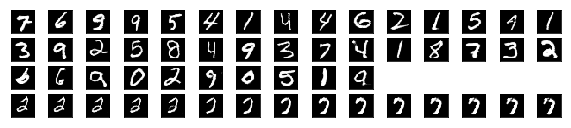

In [36]:
n_s=40
n_move=15


ims=[]

fig = plt.figure(figsize=(10, 3))

noise=torch.randn(n_s,nz,1,1,device=device)
fake_label=torch.randint(10,(n_s,),dtype=torch.long,device=device)
        
fake_noise_label=concat_noise_label(noise,fake_label,device)
x = gnet(fake_noise_label)  
x = x.to('cpu').detach().numpy().copy()

print(x.shape)
for i in range(n_s):
    ax = fig.add_subplot(6, 15, i+1, xticks=[], yticks=[])
    ax.imshow(x[i][0], 'gray')
    
print(fixed_noise.shape)
z1to0_noise = torch.cat([fixed_noise_label[7] * (i * 0.1) + fixed_noise_label[2] * ((9 - i) * 0.1) for i in range(n_move)]).reshape(n_move,110,1,1)
print(z1to0_noise .shape)

fake_image = gnet(z1to0_noise )  
x = fake_image.to('cpu').detach().numpy().copy()
for i in range(n_move):
    ax = fig.add_subplot(6, 15, i+46, xticks=[], yticks=[])
    imm=Image.fromarray(np.uint8(cm.gist_earth(x[i][0])*255))
    ims.append(imm)
    ax.imshow(x[i][0], 'gray')

In [38]:
ims[0].save('cgan.gif' , save_all = True , append_images = ims[1:] , duration = 400 , loop = 0)